# Digits
This is my notebook for playing around with the MNIST digits data set. The data set is a collection of $70000$, $28\times 28$ greyscale images of handwritten images. 

In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import random

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# reshape dataset to have a single channel
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# one hot encode target values
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat  = tf.keras.utils.to_categorical(y_test)
# normalize xvalues
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.

Now plot a few examples:

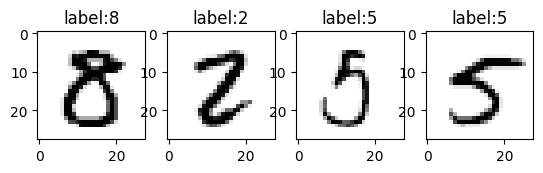

In [4]:
fig, axes = plt.subplots(1, 4)
for i, j in enumerate(random.sample(range(60000), 4)):
    axes[i].imshow(x_train[j], cmap='Greys')
    axes[i].set_title(f"label:{y_train[j]}")

In [8]:
# Build a sequential model. Since I will experiment with hyperparameter 
## optimization, encapsule this action into a function
tf.keras.backend.clear_session()
def create_uncompiled_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(28,28,1)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3)), 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='sigmoid'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [9]:
tf.keras.backend.clear_session()
model = create_uncompiled_model()
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 1936)              0         
                                                                 
 dense (Dense)               (None, 128)               247936    
                                                        

In [10]:
# callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * np.exp(-epoch/20))
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=10,
                                                           mode='auto',
                                                           restore_best_weights=True)
hist = model.fit(x_train, y_train_cat, 
                    epochs=40,
                    validation_split=0.1,
                    batch_size=64,
                    callbacks=[early_stopping_callback]
                   )

Epoch 1/40
844/844 [==============================] - 12s 13ms/step - loss: 0.3249 - accuracy: 0.9081 - val_loss: 0.1428 - val_accuracy: 0.9638
Epoch 2/40
844/844 [==============================] - 11s 13ms/step - loss: 0.1509 - accuracy: 0.9567 - val_loss: 0.0897 - val_accuracy: 0.9762
Epoch 3/40
844/844 [==============================] - 11s 13ms/step - loss: 0.0974 - accuracy: 0.9719 - val_loss: 0.0642 - val_accuracy: 0.9838
Epoch 4/40
844/844 [==============================] - 11s 13ms/step - loss: 0.0726 - accuracy: 0.9796 - val_loss: 0.0558 - val_accuracy: 0.9868
Epoch 5/40
844/844 [==============================] - 11s 13ms/step - loss: 0.0586 - accuracy: 0.9826 - val_loss: 0.0505 - val_accuracy: 0.9872
Epoch 6/40
844/844 [==============================] - 11s 13ms/step - loss: 0.0489 - accuracy: 0.9859 - val_loss: 0.0457 - val_accuracy: 0.9885
Epoch 7/40
844/844 [==============================] - 11s 13ms/step - loss: 0.0439 - accuracy: 0.9871 - val_loss: 0.0443 - val_accuracy:

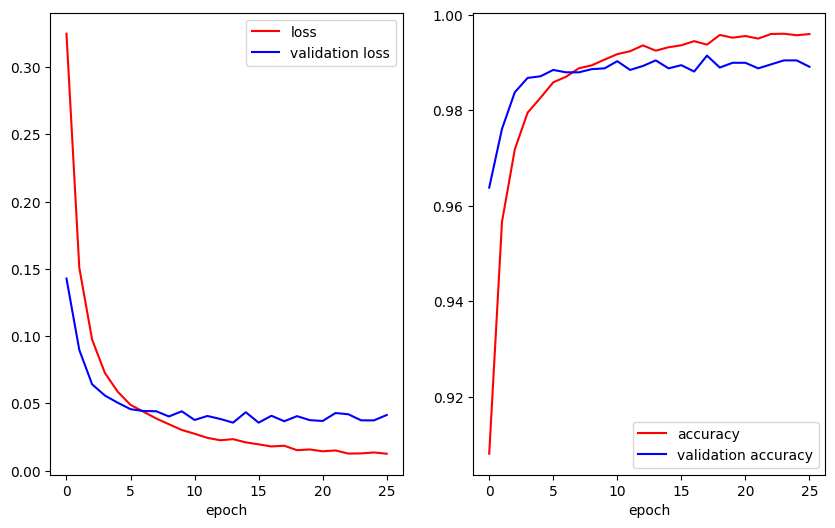

In [11]:
fig, axes = plt.subplots(1,2, figsize=(10, 6), gridspec_kw={'hspace':0.2})
axes[0].plot(hist.history['loss'], color='red', label='loss')
axes[0].plot(hist.history['val_loss'], color='blue', label='validation loss')
axes[0].set_xlabel('epoch')
axes[0].legend(loc='best')
axes[1].plot(hist.history['accuracy'], color='red', label='accuracy')
axes[1].plot(hist.history['val_accuracy'], color='blue', label='validation accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(loc='best')

In [12]:
predictions = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [13]:
predictions[0]

array([2.8746104e-08, 4.8242878e-06, 3.8263531e-07, 4.7946310e-06,
       2.6001696e-09, 1.4176085e-09, 6.7362142e-13, 9.9998832e-01,
       2.3012032e-09, 1.6985923e-06], dtype=float32)

In [14]:
acc = tf.keras.losses.CategoricalCrossentropy()
accuracy = acc(y_test_cat, predictions).numpy()

In [15]:
indices_missed = []
for iy, ypred in enumerate(predictions):
    pred_label = np.argmax(ypred)
    if pred_label != y_test[iy]:
        print(f"predicted: {pred_label}, real: {y_test[iy]}")
        indices_missed.append(iy)


predicted: 8, real: 3
predicted: 5, real: 9
predicted: 4, real: 9
predicted: 6, real: 4
predicted: 7, real: 2
predicted: 0, real: 6
predicted: 8, real: 9
predicted: 8, real: 5
predicted: 9, real: 4
predicted: 9, real: 7
predicted: 7, real: 9
predicted: 5, real: 3
predicted: 7, real: 2
predicted: 0, real: 2
predicted: 9, real: 8
predicted: 5, real: 6
predicted: 2, real: 7
predicted: 8, real: 6
predicted: 7, real: 4
predicted: 1, real: 6
predicted: 5, real: 6
predicted: 2, real: 7
predicted: 5, real: 9
predicted: 1, real: 7
predicted: 0, real: 8
predicted: 6, real: 2
predicted: 6, real: 5
predicted: 3, real: 5
predicted: 9, real: 7
predicted: 7, real: 8
predicted: 6, real: 4
predicted: 5, real: 9
predicted: 6, real: 0
predicted: 7, real: 3
predicted: 3, real: 9
predicted: 7, real: 2
predicted: 3, real: 8
predicted: 4, real: 9
predicted: 3, real: 5
predicted: 9, real: 7
predicted: 7, real: 3
predicted: 0, real: 6
predicted: 2, real: 9
predicted: 9, real: 4
predicted: 1, real: 6
predicted:

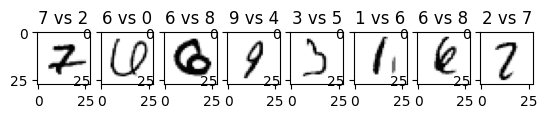

In [16]:
num_numbers = 8
fig, axes = plt.subplots(1, num_numbers)
for i, j in enumerate(random.sample(indices_missed, num_numbers)):
    prediction = np.argmax(predictions[j])
    axes[i].imshow(x_test[j], cmap='Greys')
    axes[i].set_title(f"{y_test[j]} vs {prediction}")

The accuracy on the test set is:

In [17]:
1. - len(indices_missed)/len(y_test)

0.9872

In [18]:
total_x = tf.concat([x_train, x_test], axis=0)
total_y = tf.concat([y_train_cat, y_test_cat], axis=0)

In [19]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                           patience=10,
                                                           mode='auto',
                                                           restore_best_weights=True)
final_hist = model.fit(total_x, total_y, 
                    epochs=40,
                    #validation_split=0.1,
                    batch_size=64,
                    callbacks=[early_stopping_callback]
                   )

Epoch 1/40
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0301 - accuracy: 0.9909
Epoch 2/40
1094/1094 [==============================] - 14s 13ms/step - loss: 0.0254 - accuracy: 0.9919
Epoch 3/40
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0231 - accuracy: 0.9926
Epoch 4/40
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0195 - accuracy: 0.9937
Epoch 5/40
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0197 - accuracy: 0.9935
Epoch 6/40
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0189 - accuracy: 0.9938
Epoch 7/40
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0166 - accuracy: 0.9947
Epoch 8/40
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0170 - accuracy: 0.9947
Epoch 9/40
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0165 - accuracy: 0.9949
Epoch 10/40
1094/1094 [==============================] - 13s 12m

In [20]:
model.save('./my_mnist_model.keras')